In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
import os

In [2]:
os.listdir('timeseries')

['dailyriders_all.xlsx', 'dailyriders.xlsx']

# Load data and preprocess

## Ridership Data

In [3]:
ridership = pd.read_excel('timeseries/dailyriders.xlsx', index_col=0)

In [4]:
riders = ridership.loc[5:,:]
riders = riders.reset_index(drop=True)
riders.shape

(116, 45)

In [5]:
riders.head(3)

,Month,Date,RM,EN,EP,NB,BK,AS,MA,19,...,DC,CM,CV,ED,NC,WP,SS,SB,MB,WD
0,January,2020-01-06,3967,7487,4433,3867,8548,4746,8621,13242,...,7842,4317,2636,8239,1824,3746,3422,3424,5693,3591
1,January,2020-01-07,4146,7736,4468,4045,8699,4823,8984,13957,...,7969,4408,2693,8410,1989,3897,3509,3547,5755,3597
2,January,2020-01-08,4143,7739,4561,4011,9110,4909,8934,13876,...,8081,4387,2735,8190,1164,2463,3503,3608,5772,3723


In [6]:
groups = np.arange(len(riders))//7
riders_mean = riders.groupby(groups).mean()
riders_sum = riders.groupby(groups).sum()
riders_mean.shape, riders_sum.shape

((17, 43), (17, 43))

In [7]:
riders_mean['week'] = np.arange(len(riders_mean))
riders_mean['day'] = 7 * riders_mean['week']
riders_sum['week'] = np.arange(len(riders_sum))
riders_sum['day'] = 7 * riders_sum['week']
riders_mean.head(3)

,RM,EN,EP,NB,BK,AS,MA,19,12,LM,...,CV,ED,NC,WP,SS,SB,MB,WD,week,day
0,3354.142857,6049.857143,3657.142857,3238.000000,7536.857143,3876.571429,7110.428571,10580.000000,10844.000000,5215.857143,...,2100.571429,6175.714286,1316.000000,2727.857143,2641.714286,2778.285714,4458.285714,2714.714286,0,0
1,3411.000000,6074.285714,3755.000000,3385.285714,8427.000000,3983.142857,7278.142857,10961.428571,11240.285714,5229.000000,...,2117.285714,6118.142857,1412.285714,2930.571429,2665.857143,2905.428571,4671.285714,2733.142857,1,7
2,3276.285714,5632.000000,3567.714286,3073.857143,9077.285714,3657.000000,6558.285714,9860.857143,9928.285714,5106.285714,...,1922.285714,5546.000000,1273.142857,2650.857143,2367.428571,2589.142857,4194.000000,2452.142857,2,14


In [8]:
riders = riders.assign(day=np.arange(len(riders)))
riders.head(3)

,Month,Date,RM,EN,EP,NB,BK,AS,MA,19,...,CM,CV,ED,NC,WP,SS,SB,MB,WD,day
0,January,2020-01-06,3967,7487,4433,3867,8548,4746,8621,13242,...,4317,2636,8239,1824,3746,3422,3424,5693,3591,0
1,January,2020-01-07,4146,7736,4468,4045,8699,4823,8984,13957,...,4408,2693,8410,1989,3897,3509,3547,5755,3597,1
2,January,2020-01-08,4143,7739,4561,4011,9110,4909,8934,13876,...,4387,2735,8190,1164,2463,3503,3608,5772,3723,2


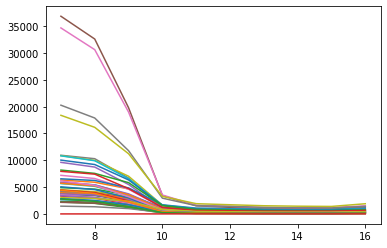

In [9]:
# fig, ax = plt.subplots(figsize=(5,3), dpi=600)
fig, ax = plt.subplots()
ax.plot(riders_mean.loc[7:,'week'], riders_mean.loc[7:,:'week']);

## Demographic Data

In [10]:
feature_mean_df = pd.read_excel('regression/feature_mean.xlsx', index_col=0)
feature_cat_df = pd.read_excel('regression/feature_cat.xlsx', index_col=0)
feature_all_df = pd.read_excel('regression/feature_all.xlsx', index_col=0)

In [11]:
min(np.array(list(feature_mean_df.index)) == np.array(list(feature_all_df.index)))

True

In [12]:
feature_mean = np.array(feature_mean_df)
feature_cat = np.array(feature_cat_df)
feature_all = np.array(feature_all_df)
feature_mean = preprocessing.scale(feature_mean, axis=0)
feature_cat = preprocessing.scale(feature_cat, axis=0)
feature_all = preprocessing.scale(feature_all, axis=0)
feature_mean.shape, feature_cat.shape, feature_all.shape

((43, 9), (43, 25), (43, 52))

# Curve fitting
Fit a logistic curve for each station

In [13]:
def rmse(x, y):
    return np.sqrt(np.mean(np.square(x - y)))

def expcurve(x, a, b, c, d):
    return a * np.exp(-b*(x - c)) + d

def logisticcurve(x, a, b, c, d):
    return a * 1/(1 + np.exp(b*(x - d))) + c

In [14]:
weekone = 0
dayone = weekone * 7

In [15]:
days = riders.loc[dayone:, 'day']
days = days - min(days)
weeks = riders_mean.loc[weekone:,'week']
weeks = weeks - min(weeks)
daily = riders.loc[dayone:, 'RM':'WD'] / 10000
weekly = riders_mean.loc[weekone:, 'RM':'WD'] / 10000
daily.shape, weekly.shape

((116, 43), (17, 43))

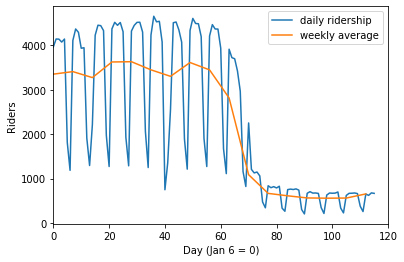

In [16]:
# fig, ax = plt.subplots(figsize=(5,3), dpi=600)
fig, ax = plt.subplots()
ax.plot(days, daily['RM']*10000, label='daily ridership');
ax.plot(weeks*7, weekly['RM']*10000, label='weekly average');
ax.set_xlabel('Day (Jan 6 = 0)')
ax.set_ylabel('Riders')
ax.set_xlim((0,120))
ax.legend();

In [17]:
daynum = np.array(days)
richmond_day = np.array(daily['RM'])
daynum.shape, richmond_day.shape

((116,), (116,))

In [18]:
popt_day, pcov_day = curve_fit(logisticcurve, daynum, richmond_day, maxfev=5000)
popt_day

array([2.89174089e-01, 5.14386817e-01, 5.99312825e-02, 6.83352517e+01])

In [19]:
weeknum = np.array(weeks)
richmond_week = np.array(weekly['RM'])
weeknum.shape, richmond_week.shape

((17,), (17,))

In [20]:
popt_week, pcov_week = curve_fit(logisticcurve, weeknum, richmond_week, maxfev=5000)
popt_week

array([-0.28669724, -2.82375035,  0.34635091,  9.44184947])

In [21]:
day_pred = logisticcurve(daynum, *popt_day)
week_pred = logisticcurve(weeknum, *popt_week)
day_true = np.array(daily['RM'])
week_true = np.array(weekly['RM'])

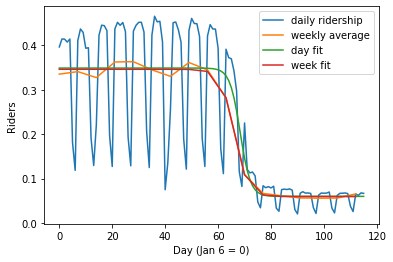

In [22]:
# fig, ax = plt.subplots(figsize=(5,3), dpi=600)
fig, ax = plt.subplots()
ax.plot(days, day_true, label='daily ridership');
ax.plot(weeks*7, week_true, label='weekly average');
ax.plot(days, day_pred, label='day fit')
ax.plot(weeks*7, week_pred, label='week fit')
ax.set_xlabel('Day (Jan 6 = 0)')
ax.set_ylabel('Riders')
ax.legend();

In [23]:
daynum = np.array(days)
weeknum = np.array(weeks)

In [24]:
params_week = {}
params_day = {}
errors_week = {}
errors_day = {}
for i in daily.columns:
    rides_day = np.array(daily[i])
    rides_week = np.array(weekly[i])
    popt_day, pcov_day = curve_fit(logisticcurve, daynum, rides_day, maxfev=10000)
    popt_week, pcov_week = curve_fit(logisticcurve, weeknum*7+2, rides_week, maxfev=10000)
    params_day[i] = popt_day
    params_week[i] = popt_week
    day_pred = logisticcurve(daynum, *popt_day)
    week_pred = logisticcurve(weeknum*7 + 2, *popt_day)
    errors_day[i] = rmse(rides_day, day_pred)
    errors_week[i] = rmse(rides_week, week_pred)

/Applications/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  


In [25]:
i='RM'
popt_day = params_day[i]
popt_week = params_week[i]
day_pred = logisticcurve(daynum, *popt_day) * 10000
week_pred = logisticcurve(weeknum*7, *popt_day) * 10000
day_true = np.array(daily[i]) * 10000
week_true = np.array(weekly[i]) * 10000
thiserr = errors_week[i] * 10000

In [26]:
thiserr

118.77979957778024

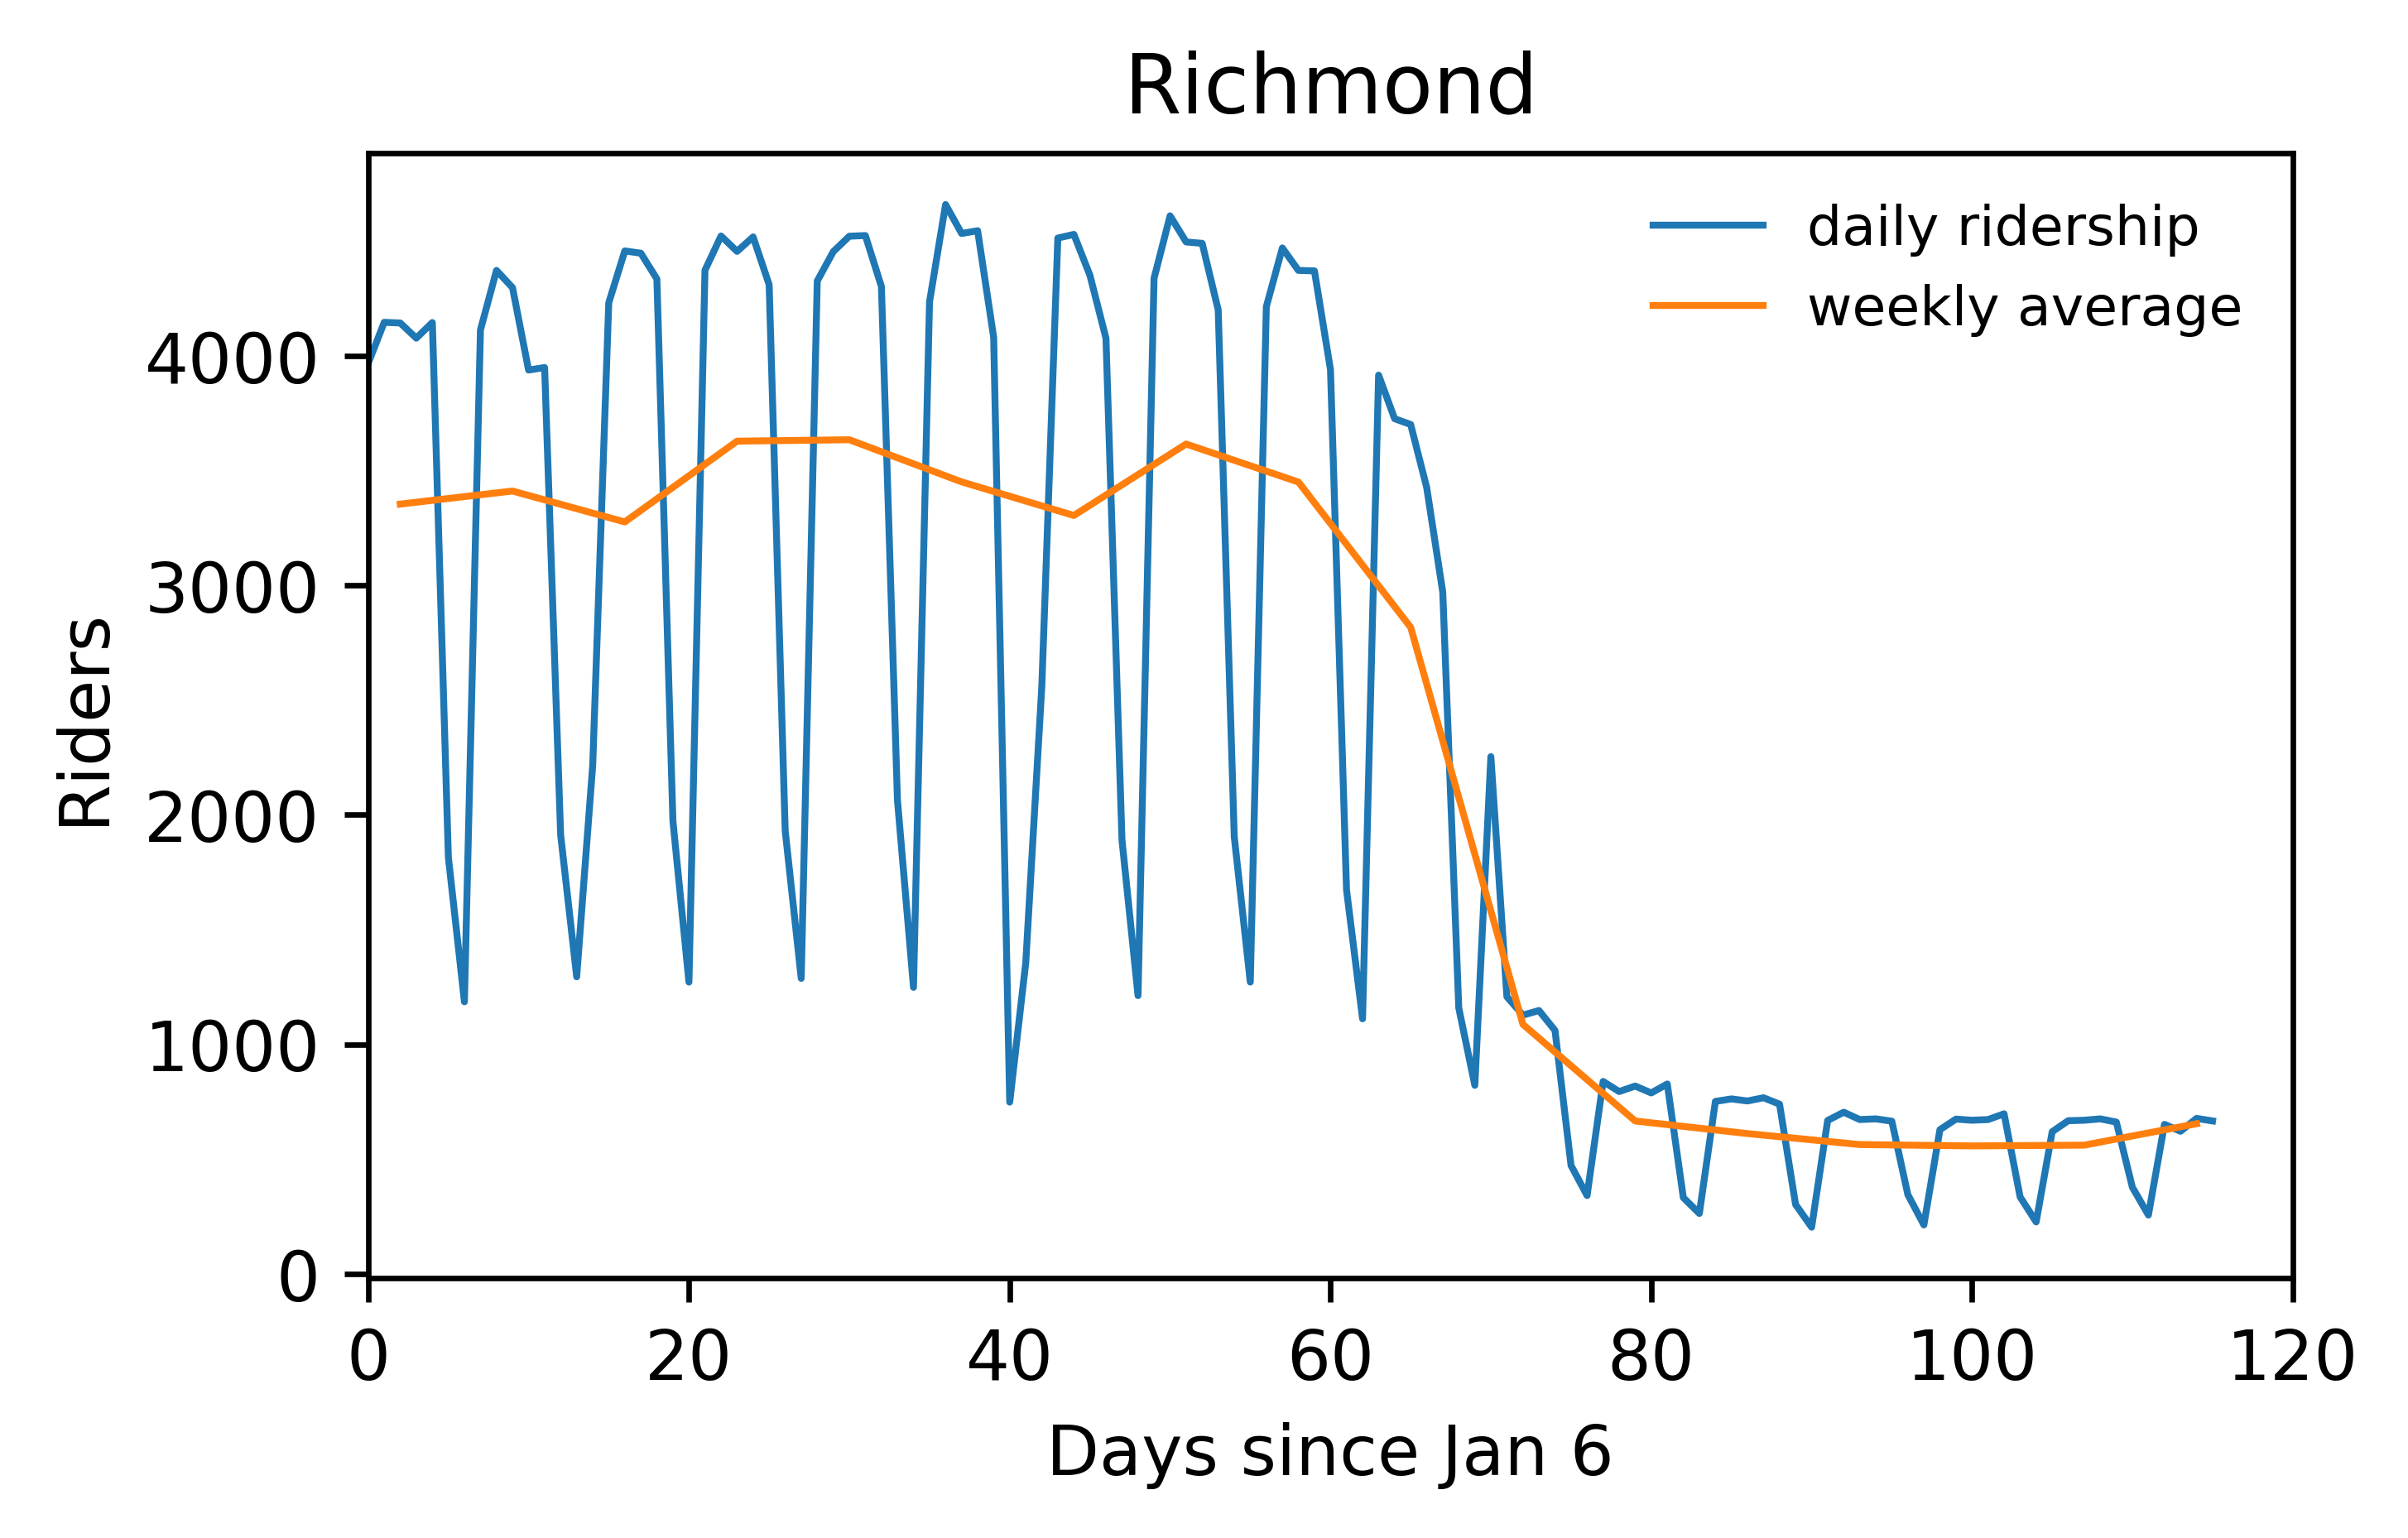

In [29]:
fig, ax = plt.subplots(figsize=(5,3), dpi=600)
# fig, ax = plt.subplots()
ax.plot(daynum, day_true, label='daily ridership', lw=1);
ax.plot(weeknum*7+2, week_true, label='weekly average', lw=1);
# ax.plot(daynum, day_pred, label='logistic fit', ls='--', lw=1)
# ax.fill_between(daynum, day_pred+2*thiserr, day_pred-2*thiserr, color='tab:green', alpha=0.25, lw=0)
# ax.plot(weeknum*7, week_pred, label='week fit', ls=':')
ax.set_xlabel('Days since Jan 6')
ax.set_ylabel('Riders')
ax.set_title('Richmond')
ax.set_xlim((0,120))
ax.legend(frameon=False, fontsize=8);
plt.savefig('../figures/richmond_blank.png', bbox_inches='tight')

In [30]:
errors_week['RM']

0.011877979957778024

In [31]:
param_df = pd.DataFrame(params_day).T
param_df.head()

,0,1,2,3
RM,0.289174,0.514387,0.059931,68.335252
EN,0.532047,0.618118,0.077972,67.809126
EP,-0.354771,-0.396816,0.377998,66.575462
NB,0.316322,0.367778,0.013642,65.758091
BK,0.872418,0.442517,0.044649,66.352064


In [32]:
param_df_week = pd.DataFrame(params_week).T
param_df_week.head()

,0,1,2,3
RM,0.286697,0.403393,0.059654,68.092944
EN,1.257023,-6.273868,-0.873473,-4.457081
EP,0.350283,0.379308,0.024134,66.152652
NB,0.312338,0.355689,0.014312,65.384707
BK,0.862471,0.429324,0.047134,65.769918


In [33]:
min(np.array(list(feature_mean_df.index)) == np.array(list(param_df.index)))

True

In [34]:
params = np.array(param_df)
params.shape

(43, 4)

In [35]:
np.mean(list(errors_day.values()))*10000

2192.4627203802847

In [36]:
np.mean(list(errors_week.values()))*10000

293.104141848352

In [37]:
param_df.mean(axis=0)

0     0.645647
1     0.564130
2     0.055622
3    66.533323
dtype: float64

# Predictive Modelling

## Train/Test split (75/25)

In [67]:
params = np.array(param_df)

In [68]:
splits = model_selection.train_test_split(feature_mean, feature_cat, feature_all, params, test_size=0.25)
xtrain_mean = splits[0]
xtest_mean = splits[1]
xtrain_cat = splits[2]
xtest_cat = splits[3]
xtrain_all = splits[4]
xtest_all = splits[5]
ytrain = splits[6]
ytest = splits[7]
xtrain_mean.shape, xtest_mean.shape, xtrain_cat.shape, xtest_cat.shape, xtrain_all.shape, xtest_all.shape

((32, 9), (11, 9), (32, 25), (11, 25), (32, 52), (11, 52))

In [69]:
ytrain.shape, ytest.shape

((32, 4), (11, 4))

## OLS

In [244]:
xtrain = xtrain_mean
xtest = xtest_mean

In [245]:
model = linear_model.LinearRegression()

In [246]:
model.fit(xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [247]:
ypred_train = model.predict(xtrain)
rmse_train = np.sqrt(metrics.mean_squared_error(ytrain, ypred_train, multioutput='raw_values'))
rmse_train / np.mean(ytrain, axis=0) * 100

array([  86.87411345, -491.8920119 , 6945.97924504,   55.24811438])

In [248]:
ypred_test = model.predict(xtest)
rmse_ols = np.sqrt(metrics.mean_squared_error(ytest, ypred_test, multioutput='raw_values'))
pcterr_ols = rmse_ols / np.mean(ytest, axis=0) * 100

In [249]:
rmse_ols, pcterr_ols

(array([ 0.96274666,  5.82790432,  0.64033966, 42.65572419]),
 array([ 277.53119199, -697.67814966,  285.00546945,  106.06479149]))

## Ridge Regression

In [250]:
xtrain = xtrain_mean
xtest = xtest_mean

In [251]:
loo = model_selection.LeaveOneOut()
mse_scorer = metrics.make_scorer(metrics.mean_squared_error, greater_is_better=False, multioutput='uniform_average')
model = linear_model.RidgeCV(scoring=mse_scorer, cv=loo)

In [252]:
model.fit(xtrain, ytrain)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=LeaveOneOut(), fit_intercept=True,
        gcv_mode=None, normalize=False,
        scoring=make_scorer(mean_squared_error, greater_is_better=False, multioutput=uniform_average),
        store_cv_values=False)

In [253]:
ypred_train = model.predict(xtrain)
rmse_train = np.sqrt(metrics.mean_squared_error(ytrain, ypred_train, multioutput='raw_values'))
rmse_train / np.mean(ytrain, axis=0) * 100

array([  90.15849172, -497.35144284, 7092.40334298,   56.01016201])

In [254]:
ypred_test = model.predict(xtest)
rmse_ridge = np.sqrt(metrics.mean_squared_error(ytest, ypred_test, multioutput='raw_values'))
pcterr_ridge = rmse_ridge / np.mean(ytest, axis=0) * 100

In [255]:
rmse_ridge, pcterr_ridge

(array([ 0.89031174,  5.5784478 ,  0.64187092, 40.61093905]),
 array([ 256.65036266, -667.81486441,  285.687007  ,  100.98036932]))

## Lasso Regression

In [256]:
xtrain = xtrain_mean
xtest = xtest_mean

In [257]:
loo = model_selection.LeaveOneOut()
model = linear_model.MultiTaskLassoCV(cv=loo, max_iter=5000)

In [258]:
model.fit(xtrain, ytrain)

MultiTaskLassoCV(alphas=None, copy_X=True, cv=LeaveOneOut(), eps=0.001,
                 fit_intercept=True, max_iter=5000, n_alphas=100, n_jobs=None,
                 normalize=False, random_state=None, selection='cyclic',
                 tol=0.0001, verbose=False)

In [259]:
ypred_train = model.predict(xtrain)
rmse_train = np.sqrt(metrics.mean_squared_error(ytrain, ypred_train, multioutput='raw_values'))
rmse_train / np.mean(ytrain, axis=0) * 100

array([ 102.5181551 , -518.2638986 , 7146.25279121,   60.6038756 ])

In [260]:
ypred_test = model.predict(xtest)
rmse_lasso = np.sqrt(metrics.mean_squared_error(ytest, ypred_test, multioutput='raw_values'))
pcterr_lasso = rmse_lasso / np.mean(ytest, axis=0) * 100

In [261]:
rmse_lasso, pcterr_lasso

(array([ 0.83456128,  5.3813844 ,  0.63537027, 37.63671601]),
 array([ 240.57916599, -644.22373782,  282.7936681 ,   93.58487077]))

## Elastic Net Regression

In [70]:
xtrain = xtrain_mean
xtest = xtest_mean

In [71]:
loo = model_selection.LeaveOneOut()
mse_scorer = metrics.make_scorer(metrics.mean_squared_error, greater_is_better=False, multioutput='uniform_average')
model = linear_model.MultiTaskElasticNetCV(cv=loo, max_iter=50000, l1_ratio=0.7)

In [72]:
model.fit(xtrain, ytrain)

MultiTaskElasticNetCV(alphas=None, copy_X=True, cv=LeaveOneOut(), eps=0.001,
                      fit_intercept=True, l1_ratio=0.7, max_iter=50000,
                      n_alphas=100, n_jobs=None, normalize=False,
                      random_state=None, selection='cyclic', tol=0.0001,
                      verbose=0)

In [73]:
ypred_train = model.predict(xtrain)
rmse_train = np.sqrt(metrics.mean_squared_error(ytrain, ypred_train, multioutput='raw_values'))
rmse_train / np.mean(ytrain, axis=0) * 100

array([55.12497097, 74.26358163, 54.2168769 ,  0.75907096])

In [74]:
ypred_test = model.predict(xtest)
rmse_elastic = np.sqrt(metrics.mean_squared_error(ytest, ypred_test, multioutput='raw_values'))
pcterr_elastic = rmse_elastic / np.mean(ytest, axis=0) * 100

In [75]:
rmse_elastic, pcterr_elastic

(array([1.23956137, 1.06775674, 0.1107524 , 0.4877498 ]),
 array([121.97298095, 138.04989987, 112.79019457,   0.73401215]))

In [76]:
predicted_params = model.predict(feature_mean)
predicted_params.shape

(43, 4)

In [77]:
predicted_params_df = pd.DataFrame(data=predicted_params, index=param_df.index, columns=param_df.columns)
predicted_params_df.head(3)

,0,1,2,3
RM,0.312515,0.735188,0.043164,67.816587
EN,0.502248,0.567136,0.045450,67.094046
EP,0.581223,0.507984,0.043771,66.594789


In [78]:
param_df.head(3)

,0,1,2,3
RM,0.289174,0.514387,0.059931,68.335252
EN,0.532047,0.618118,0.077972,67.809126
EP,-0.354771,-0.396816,0.377998,66.575462


In [79]:
pcterr_elastic

array([121.97298095, 138.04989987, 112.79019457,   0.73401215])

In [80]:
i='RM'
popt_day = params_day[i]
popt_week = params_week[i]
day_pred = logisticcurve(daynum, *popt_day) * 10000
week_pred = logisticcurve(weeknum*7, *popt_day) * 10000
day_true = np.array(daily[i]) * 10000
week_true = np.array(weekly[i]) * 10000
thiserr = errors_week[i] * 10000
model_param = np.array(predicted_params_df.loc[i,:])
day_pred_model = logisticcurve(daynum, *model_param) * 10000

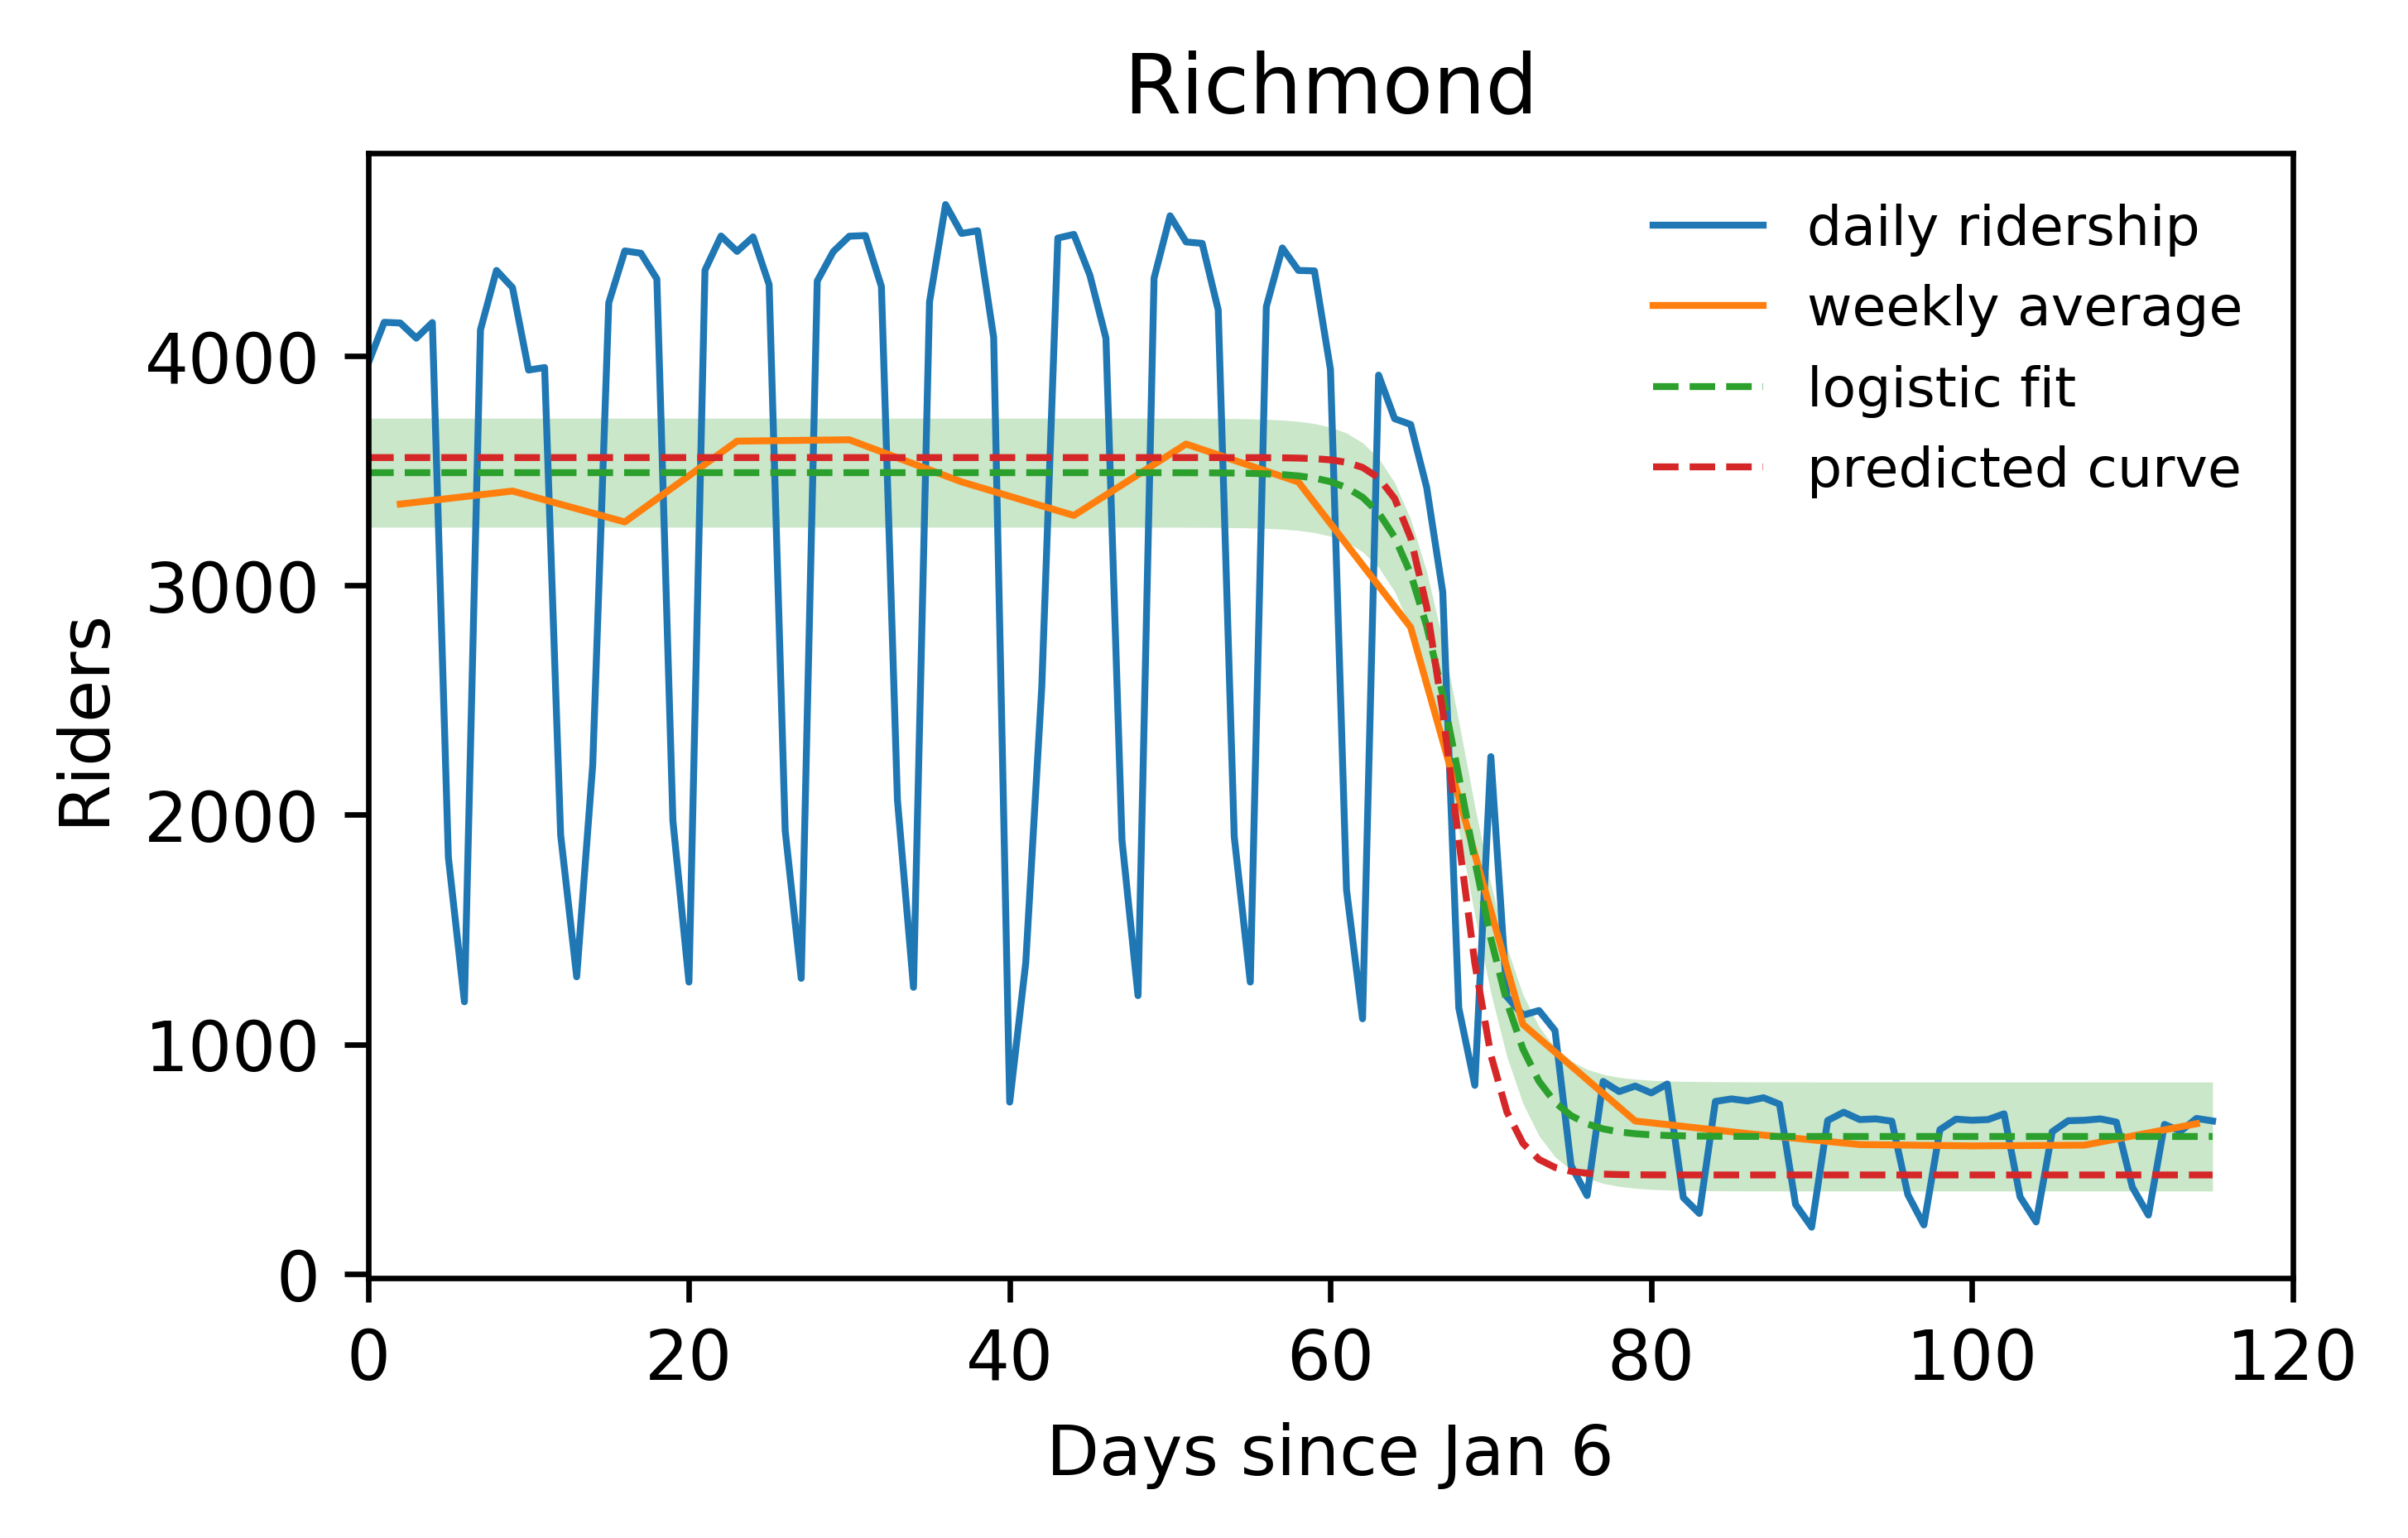

In [82]:
fig, ax = plt.subplots(figsize=(5,3), dpi=600)
# fig, ax = plt.subplots()
ax.plot(daynum, day_true, label='daily ridership', lw=1);
ax.plot(weeknum*7+2, week_true, label='weekly average', lw=1);
ax.plot(daynum, day_pred, label='logistic fit', ls='--', lw=1)
ax.plot(daynum, day_pred_model, label='predicted curve', ls='--', lw=1)
ax.fill_between(daynum, day_pred+2*thiserr, day_pred-2*thiserr, color='tab:green', alpha=0.25, lw=0)
# ax.plot(weeknum*7, week_pred, label='week fit', ls=':')
ax.set_xlabel('Days since Jan 6')
ax.set_ylabel('Riders')
ax.set_title('Richmond')
ax.set_xlim((0,120))
ax.legend(frameon=False, fontsize=8);
plt.savefig('../figures/richmond_final.png', bbox_inches='tight')

## Export results

In [190]:
all_rmse = np.vstack((rmse_ols, rmse_ridge, rmse_lasso, rmse_elastic))
all_pcterr = np.vstack((pcterr_ols, pcterr_ridge, pcterr_lasso, pcterr_elastic))

In [191]:
cols = ['a', 'b', 'c', 'd']
rows=['ols', 'ridge', 'lasso', 'elastic']

In [192]:
rmse_df = pd.DataFrame(data=all_rmse, columns=cols, index=rows)
pcterr_df = pd.DataFrame(data=all_pcterr, columns=cols, index=rows)

In [193]:
rmse_df

,a,b,c,d
ols,0.457064,1.187379,0.050772,0.674047
ridge,0.406476,1.061155,0.036789,0.591219
lasso,0.406332,1.041818,0.036445,0.590740
elastic,0.405696,1.040492,0.036257,0.593215


In [194]:
pcterr_df

,a,b,c,d
ols,75.412350,136.822728,92.364638,1.011916
ridge,67.065714,122.277812,66.926839,0.887570
lasso,67.041962,120.049655,66.301170,0.886851
elastic,66.937090,119.896835,65.959558,0.890566


In [195]:
rmse_df.to_excel('rmse.xlsx')
pcterr_df.to_excel('pcterr.xlsx')

# Apply Predicted Model